---

# Supplementary notebook for leaf wood segmentation paper


August 2023 \
Wouter Van den Broeck

---

## 1. Evaluating leaf wood segmentation results

In [8]:
# Load packages
import numpy as np
import pandas as pd
import os

In [10]:
# Process GBSeparation files into correct format

data_path =  '/mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/preprocessed_open3d/test_pred_gbseparation/'

filenames_wood = [filename for filename in os.listdir(data_path) if len(filename.split('wood')) == 2]
filenames_leaf = [filename for filename in os.listdir(data_path) if len(filename.split('leaf')) == 2]

for file_wood, file_leaf in zip(filenames_wood, filenames_leaf):
    # Read woody and leaf points
    wood = np.loadtxt(data_path + file_wood)
    leaf = np.loadtxt(data_path + file_leaf)

    # Add label column
    wood = np.hstack((wood, np.ones(shape=(wood.shape[0], 1))))
    leaf = np.hstack((leaf, np.zeros(shape=(leaf.shape[0], 1))))

    # Stack together    
    combo = np.vstack((wood, leaf))

    # Save to file
    path_out = data_path + file_wood.split('wood')[0] + file_wood.split('wood')[1]
    np.savetxt(path_out, combo, fmt='%.3f')


In [28]:
def get_iou(confusion_matrix):
    ious = []
    for label in range(len(confusion_matrix)):
        tp = np.longlong(confusion_matrix[label, label])
        fn = np.longlong(confusion_matrix[label, :].sum()) - tp
        fp = np.longlong(confusion_matrix[:, label].sum()) - tp

        if tp + fp + fn == 0:
            iou = float('nan')
        else:
            iou = (tp) / (tp + fp + fn)

        ious.append(iou)

    ious.append(np.nanmean(ious))
    return ious


def evaluate_prediction(path_true, path_pred):

    filenames = os.listdir(path_pred)
    print('running evaluation on', len(filenames), 'files for', path_pred)

    # Loop over ground truth and predictions and keep track of metrics
    TP, FP, TN, FN = 0, 0, 0, 0
    cm = 0

    for filename in filenames:
        # Load ground truth and prediction
        gt = np.loadtxt(os.path.join(path_true, filename))
        try:
            pred = np.loadtxt(os.path.join(path_pred, filename))
        except:
            raise Warning(f'No ground truth file found with name {filename}')

        if len(gt) != len(pred):
            raise Exception(f'Length of prediction file and ground truth file ({filename}) do not match!')

        gt = gt[gt[:, 0].argsort()]
        gt = gt[gt[:, 1].argsort(kind='mergesort')]
        gt = gt[gt[:, 2].argsort(kind='mergesort')]
        pred = pred[pred[:, 0].argsort()]
        pred = pred[pred[:, 1].argsort(kind='mergesort')]
        pred = pred[pred[:, 2].argsort(kind='mergesort')]

        # get label
        gt = gt[:, 3].flatten().astype(np.uint16)
        pred = pred[:, 3].flatten().astype(np.uint16)

        TP += ((gt == 1) & (pred == 1)).sum()
        TN += ((gt == 0) & (pred == 0)).sum()
        FP += ((gt == 0) & (pred == 1)).sum()
        FN += ((gt == 1) & (pred == 0)).sum()

        C = len(np.unique(gt))
        y = np.bincount(C * gt + pred, minlength=C * C)

        if len(y) < C * C:
            y = np.concatenate([y, np.zeros((C * C - len(y)), dtype=np.long)])
        else:
            if len(y) > C * C:
                warnings.warn(
                    "Prediction has fewer classes than ground truth. This may affect accuracy."
                )
            y = y[-(C * C):]  # last c*c elements.

        y = y.reshape(C, C)
        cm += y

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    # precision = TP / (TP + FP)
    # recall = TP / (TP + FN)
    # iou = TP / (TP + FN + FP)
    # f1 = (2 * TP) / (2 * TP + FP + FN)

    # print(
    #     'TP:', TP, 'TN:', TN, 'FP:', FP, 'FN:', FN, '\n'
    #     'accuracy:', accuracy, '\n',
    #     'precision:', precision, '\n',
    #     'recall:', recall, '\n',
    #     'iou:', iou, '\n',
    #     'f1:', f1, '\n',
    # )
    # np.concatenate((get_iou(cm), accuracy))
    metrics = get_iou(cm) + [accuracy]
    df = pd.DataFrame(np.array(metrics).reshape(1, 4), columns=['iou_leaf', 'iou_wood', 'iou_mean', 'accuracy'])
    return df

# Specify data paths
data_path =  '/mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/'
dir_true = 'preprocessed/'
dir_pred = [
    'preprocessed_open3d/test_pred_LeWOS/',
    'preprocessed_open3d/test_pred_gbseparation/',
    'preprocessed_open3d/test_pred_kpconv/',
    'preprocessed_open3d/test_pred_randlanet/',
    'preprocessed_open3d/test_pred_pointTransformer/',
]

# Initialize empty dataframe
df_result = pd.DataFrame()

# Loop over folders and store prediction metrics in dataframe 
for dir in dir_pred:
    path_true = os.path.join(data_path, dir_true)
    path_pred = os.path.join(data_path, dir)

    # Get name of algorithm out of directory
    index = dir.split('_')[-1][:-1]

    # Calculate metrics
    metrics = evaluate_prediction(path_true, path_pred)

    # Concatenate to dataframe
    metrics['algorithm'] = index
    df_result = pd.concat([df_result, metrics])

# Save dataframe to file
df_result = df_result.set_index('algorithm')
path_result = '/mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/preprocessed_open3d/benchmark_metrics.csv'
df_result.to_csv(path_result)

print(df_result)

running evaluation on 30 files for /mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/preprocessed_open3d/test_pred_LeWOS/
running evaluation on 30 files for /mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/preprocessed_open3d/test_pred_gbseparation/
running evaluation on 30 files for /mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/preprocessed_open3d/test_pred_kpconv/
running evaluation on 30 files for /mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/preprocessed_open3d/test_pred_randlanet/
running evaluation on 30 files for /mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/preprocessed_open3d/test_pred_pointTransformer/
                  iou_leaf  iou_wood  iou_mean  accuracy
algorithm                                               
LeWOS             0.923044  0.735583  0.829314  0.936614
gbseparation      0.902130  0.678152  0.790141  0.918862

In [19]:
metrics = [1, 2, 3, 4]
df = pd.DataFrame(np.array(metrics).reshape(1, 4), columns=['iou_leaf', 'iou_wood', 'iou_mean', 'accuracy'])

metrics = [5, 6, 7, 8]
df2 = pd.DataFrame(np.array(metrics).reshape(1, 4), columns=['iou_leaf', 'iou_wood', 'iou_mean', 'accuracy'])

df3 = pd.DataFrame()

pd.concat([df3, df2]).reset_index(drop=True)

,iou_leaf,iou_wood,iou_mean,accuracy
0,5,6,7,8


## 2. Save prediction results with error column

In [41]:
# Specify data paths
data_path =  '/mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/'
dir_true = 'preprocessed/'
dir_pred = [
    'preprocessed_open3d/test_pred_LeWOS/',
    'preprocessed_open3d/test_pred_pointTransformer_isprs/',
    'preprocessed_open3d/test_pred_randlanet_isprs/',
]
dir_out = 'preprocessed_open3d/test_pred_all_isprs/'
path_true = os.path.join(data_path, dir_true)

# Get names of predicted point clouds
filenames = os.listdir(os.path.join(data_path, dir_pred[0]))

# Loop over all files
for filename in filenames:
    # Load ground truth, sort, and get labels
    gt = np.loadtxt(os.path.join(path_true, filename))
    gt = gt[gt[:, 0].argsort()]
    gt = gt[gt[:, 1].argsort(kind='mergesort')]
    gt = gt[gt[:, 2].argsort(kind='mergesort')]
    gt_labels = gt[:, 3].flatten().astype(np.uint16)

    # Pre-allocate matrix holding the prediction confusion
    label_eval = np.zeros((len(gt), len(dir_pred)), dtype=np.uint8)

    # Loop over predictions from different algorithms
    for i, dir in enumerate(dir_pred):
        path_pred = os.path.join(data_path, dir)
        pred = np.loadtxt(os.path.join(path_pred, filename))
        pred = pred[pred[:, 0].argsort()]
        pred = pred[pred[:, 1].argsort(kind='mergesort')]
        pred = pred[pred[:, 2].argsort(kind='mergesort')]
        pred_labels = pred[:, 3].flatten().astype(np.uint16)

        label_eval[((gt_labels == 0) & (pred_labels == 0)), i] = 0
        label_eval[((gt_labels == 1) & (pred_labels == 1)), i] = 1
        label_eval[((gt_labels == 1) & (pred_labels == 0)), i] = 2
        label_eval[((gt_labels == 0) & (pred_labels == 1)), i] = 3
    
    # Save file
    pcl_out = np.hstack((gt, label_eval))
    path_out = os.path.join(data_path, dir_out, filename)
    np.savetxt(path_out, pcl_out, fmt='%.3f')
    



## Code for converting txt files to ply files, and ply files to npy files

In [20]:
import open3d as o3d

data_path =  '/mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/'
filenames = [f[:-3] + 'txt' for f in os.listdir(data_path + 'preprocessed_open3d/test') if f[-3:] == 'npy']

for filename in filenames:
    # Read file
    pcl = np.loadtxt(os.path.join(data_path, 'preprocessed', filename))
    xyz = pcl[:, :3]
    labels = pcl[:, -1].reshape(-1, 1)

    # Convert to open3d tensor format
    device = o3d.core.Device("CPU:0")
    pcd = o3d.t.geometry.PointCloud(device)
    pcd.point.positions = o3d.core.Tensor(xyz, o3d.core.float32, device)
    pcd.point.labels = o3d.core.Tensor(labels, o3d.core.int32, device)

    # Write as ply file
    file_out = os.path.join(data_path, 'preprocessed_open3d/test_ply', filename[:-3] + 'ply')
    o3d.t.io.write_point_cloud(file_out, pcd, write_ascii=False, compressed=False, print_progress=False)


    




In [28]:
import open3d as o3d
import numpy as np

path = '/mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/'
filenames = os.listdir(path + 'Tiles/')

for filename in filenames:
    print(filename)
    pcl = o3d.t.io.read_point_cloud(path + 'Tiles/' + filename)
    xyz = pcl.point.positions.numpy()
    labels = pcl.point.labels.numpy()
    pcl = np.hstack((xyz, labels))
    with open(path + 'Tiles_npy/' + filename[:-3] + 'npy', 'wb') as f:
        np.save(f, pcl)
    


Tile_0.ply
Tile_1.ply
Tile_2.ply
Tile_3.ply


## Figure for volume estimation

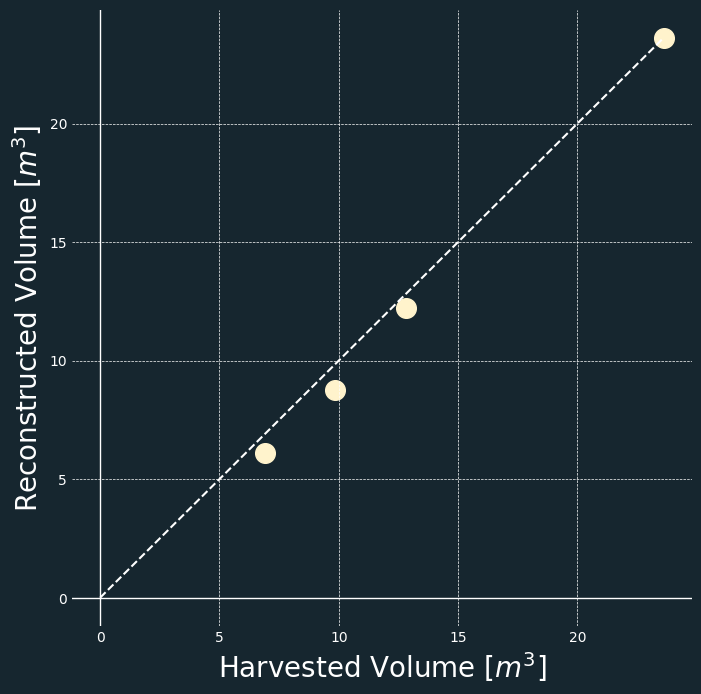

In [1]:
import matplotlib.pyplot as plt

# Data
y_values = [6.10, 23.62, 12.21, 8.74]
x_values = [6.89, 23.62, 12.81, 9.83]

# Plot settings
fig = plt.figure(figsize=(8, 8), facecolor='#16262F')
ax = plt.axes()
ax.set_facecolor('#16262F')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.scatter(x_values, y_values, s=200, color='#FFF3CC') 
plt.plot([0, max(x_values)], [0, max(y_values)], linestyle='dashed', color='white')
plt.axhline(0, color='white', linewidth=1)
plt.axvline(0, color='white', linewidth=1)
plt.ylabel('Reconstructed Volume [$m^3$]', color='white', fontsize=20)
plt.xlabel('Harvested Volume [$m^3$]', color='white', fontsize=20)
plt.xticks(color='white')
plt.yticks(color='white')
plt.tick_params(axis='both', which='both', length=0)
plt.grid(color='white', linestyle='--', linewidth=0.5)

# Show plot
plt.show()

# Save plot
figname = '/mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/conferences-summerschools/2023_ISPRS_Geospatial_week/figures/volume_scatter.png'
fig.savefig(figname, dpi=300)



## Figure for explaining training and inference

In [29]:
import numpy as np

# Read tree point cloud
path = '/mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/preprocessed/'
filename = 'rc_172_pc.txt'
pcl = np.loadtxt(path + filename)

num_points = 65536
dist_col = np.random.rand(len(pcl), 1) * 0.001
selec_col = np.zeros((len(pcl), 1))
selec_col_2 = np.zeros((len(pcl), 1))

# First iteration
init_idx = np.argmin(dist_col)
dist = np.sum(np.square(pcl[:, :3] - pcl[init_idx, :3]), 1)
dist_normalized = 1 - dist / np.max(dist)
crop_idx = np.argsort(dist)[:num_points]
dist_col[crop_idx] = dist_normalized[crop_idx].reshape(-1, 1)
selec_col[crop_idx] = 1

# Second iteration
init_idx = np.argmin(dist_col)
dist_2 = np.sum(np.square(pcl[:, :3] - pcl[init_idx, :3]), 1)
dist_normalized_2 = 1 - dist_2 / np.max(dist_2)
crop_idx_2 = np.argsort(dist_2)[:num_points]
dist_col_2 = dist_col.copy()
dist_col_2[crop_idx_2] = dist_normalized_2[crop_idx_2].reshape(-1, 1)
selec_col_2[crop_idx_2] = 1

# Save output
path_out = '/mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/conferences-summerschools/2023_ISPRS_Geospatial_week/figures/training_example.txt'
pcl_out = np.hstack((pcl, dist_col, selec_col, dist_col_2, selec_col_2))
np.savetxt(path_out, pcl_out, fmt='%.3f')